# Test code for computing registration metrics (reproducibilty) 

1. Check xcorr_vol between two outputs of the two preproc runs 
2. Check registration params
    - xfminvert stx2_052_S_1251_20070309_t1.xfm test.xfm
    - xfm2param test.xfm


**Expected use case:** 
    Run this script after preprocessing is complete to provide info on each subject

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import re
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

# Local packages
sys.path.append('../')
from lib.minc_wrap import *
from lib.preproc_checks import *

# Data paths

In [6]:
data_dir = '/Users/nikhil/projects/MR_preproc_dash/data/'
script_dir = '/Users/nikhil/code/git_repos/MR_preproc_dash/scripts/'
preproc_pipeline_dir = '/Users/nikhil/code/git_repos/nist_mni_pipelines/'

if preproc_pipeline_dir not in sys.path:
    sys.path.append(preproc_pipeline_dir)
    
#source /opt/minc/1.9.16/minc-toolkit-config.sh #Mac laptop
#source /ipl/quarantine/experimental/2013-02-15/init.sh #BIC systems

local_env = '/opt/minc/1.9.16/minc-toolkit-config.sh' 

# Calling minc from python
**Using subprocess (a bit hacky but easier than pyminc interface!)**

In [8]:
# Single timepoint 
vol1 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.mnc'
vol2 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.mnc'
xfm = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.xfm'

xcorr = get_xcorr_vol(local_env, script_dir, vol1, vol2)
reg_param = get_reg_params(local_env, script_dir, xfm)

print(xcorr)
print(reg_param)

1.0
                   x        y        z
center             0        0        0
translation   2.0631  43.5027  7.50818
rotation     2.59585  0.26141 -0.98333
scale        0.94557  0.95997  0.87936
shear        0.00055 -0.00056  0.00873


In [9]:
# Get reg_params for all timepoints
subjects = ['052_S_4807']
timepoints = ['20121019', '20130215', '20130813', '20140807', '20150804']
reg_cols = ['x_center', 'y_center', 'z_center', 'x_rotation', 'y_rotation',
       'z_rotation', 'x_scale', 'y_scale', 'z_scale', 'x_shear', 'y_shear',
       'z_shear', 'x_translation', 'y_translation', 'z_translation']

reg_param_list_subject = []
reg_param_flat_subject = pd.DataFrame()
for s, subject_idx in enumerate(subjects):
    reg_param_flat_tp, reg_param_list_tp = get_subject_reg_parameters(data_dir, local_env, script_dir, subject_idx,timepoints,'stx2')
    reg_param_flat_subject = reg_param_flat_subject.append(reg_param_flat_tp)
    reg_param_list_subject = reg_param_list_subject + reg_param_list_tp
    
print(pd.concat(reg_param_list_subject).groupby(level=0).mean())
print(pd.concat(reg_param_list_subject).groupby(level=0).std())

                    x          y         z
center       0.000000   0.000000  0.000000
rotation     2.104468  -0.820536 -0.632038
scale        0.982086   0.950380  0.871328
shear       -0.000522   0.003266  0.002924
translation  0.432874  43.615914  1.989668
                    x         y         z
center       0.000000  0.000000  0.000000
rotation     3.979364  0.833277  1.122253
scale        0.003543  0.000737  0.004030
shear        0.001189  0.003541  0.012934
translation  1.931367  1.740432  2.997615


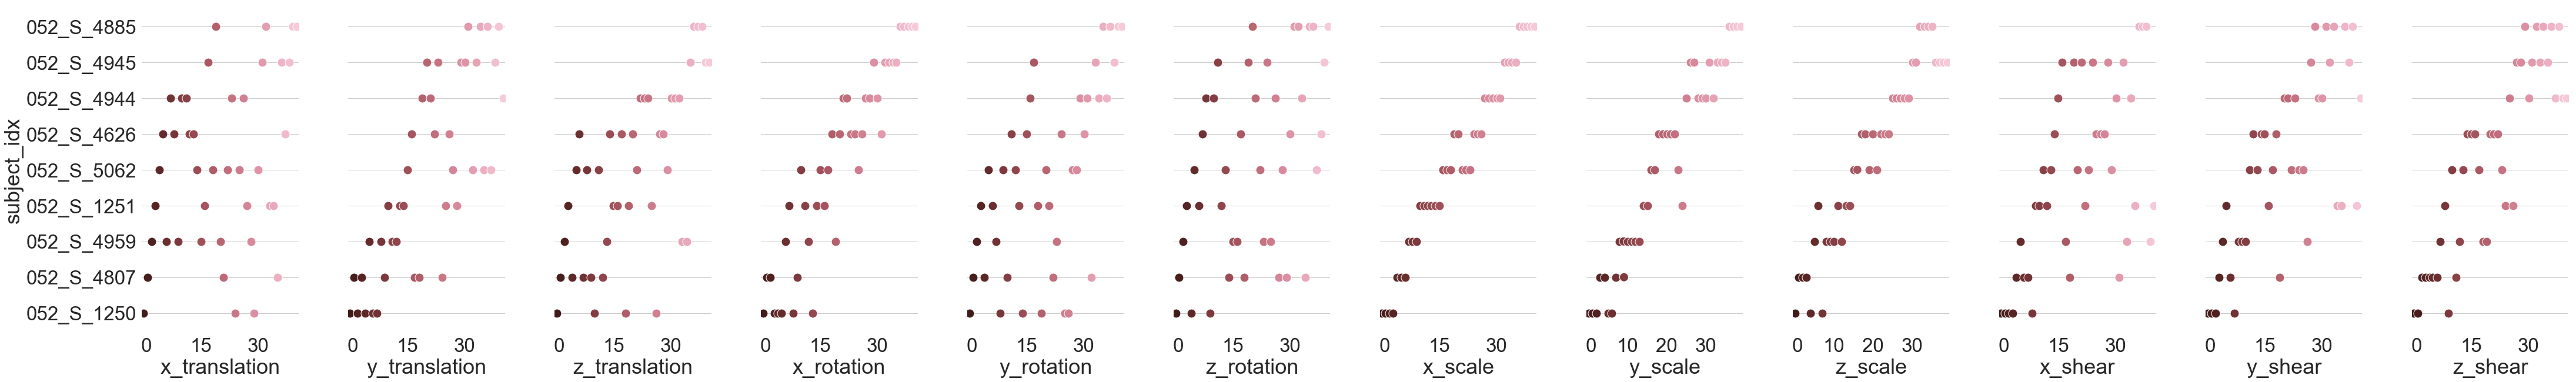

In [10]:
# Make the PairGrid
dash_df = pd.read_pickle('/Users/nikhil/Downloads/test_dash_output.pkl')
plot_df = dash_df[dash_df['stx']=='stx']
sns.set(style="whitegrid",font_scale=3)
g = sns.PairGrid(plot_df,
                 x_vars=plot_df.columns[3:15], y_vars=["subject_idx"],
                 height=10, aspect=.5)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="v",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

#[plt.setp(g.get_xticklabels(), rotation=90) for g in g.axes.flat]
[g.xaxis.set_major_formatter(FormatStrFormatter('%2.f')) for g in g.axes.flat]
[g.xaxis.set_major_locator(ticker.MaxNLocator(4, prune="both")) for g in g.axes.flat]

# Make the grid horizontal instead of vertical
for ax in g.axes.flat:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)